In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install jax flax optax
%pip install numpy tensorflow matplotlib ml_collections

In [ ]:
!git clone https://github.com/google-research/maskgit.git

In [1]:
!nvidia-smi

Wed Apr 20 22:03:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%cd maskgit
%ls

/content/maskgit
CONTRIBUTING.md  LICENSE   MaskGIT_demo.ipynb  requirements.txt
imgs/            maskgit/  README.md


In [8]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [6]:
import os
import io
import flax
import functools
import itertools
import jax
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import ImageFilter, Image
import requests
import cv2
from skimage.metrics import structural_similarity as ssim

import maskgit
from maskgit.utils import visualize_images, read_image_from_url, restore_from_path, draw_image_with_bbox, Bbox
from maskgit.inference import ImageNet_class_conditional_generator
from maskgit.nets import vqgan_tokenizer, maskgit_transformer
from maskgit.configs import maskgit_class_cond_config
from maskgit.libml import parallel_decode

In [9]:
!mkdir -p checkpoints/

models_to_download = itertools.product( 
    *[ ["maskgit", "tokenizer"],   [512] ])

for (type_, resolution) in models_to_download:
  canonical_path = ImageNet_class_conditional_generator.checkpoint_canonical_path(type_, resolution)
  if os.path.isfile(canonical_path):
    print(f"Checkpoint for {resolution} {type_} already exists, not downloading again")
  else:
    source_url = f'https://storage.googleapis.com/maskgit-public/checkpoints/{type_}_imagenet{resolution}_checkpoint'
    !wget {source_url} -O {canonical_path}

--2022-04-20 22:04:55--  https://storage.googleapis.com/maskgit-public/checkpoints/maskgit_imagenet512_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 692202904 (660M) [application/octet-stream]
Saving to: ‘./checkpoints/maskgit_imagenet512_checkpoint’

./checkpoints/maskg 100%[===================>] 660.14M   105MB/s    in 6.8s    

2022-04-20 22:05:03 (97.4 MB/s) - ‘./checkpoints/maskgit_imagenet512_checkpoint’ saved [692202904/692202904]

--2022-04-20 22:05:03--  https://storage.googleapis.com/maskgit-public/checkpoints/tokenizer_imagenet512_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connecte

In [55]:
!wget https://storage.googleapis.com/yy3185/sr_maskgit_checkpoint -O ./checkpoints/sr_maskgit_checkpoint

--2022-04-20 22:49:26--  https://storage.googleapis.com/yy3185/sr_maskgit_checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 692202904 (660M) [application/octet-stream]
Saving to: ‘./checkpoints/sr_maskgit_checkpoint’

./checkpoints/sr_ma 100%[===================>] 660.14M   315MB/s    in 2.1s    

2022-04-20 22:49:29 (315 MB/s) - ‘./checkpoints/sr_maskgit_checkpoint’ saved [692202904/692202904]



In [10]:
# TRANSFORMER_MODEL_PATH = './checkpoints/maskgit_imagenet512_checkpoint' # original imagenet checkpoint
TRANSFORMER_MODEL_PATH = './checkpoints/sr_maskgit_checkpoint'
TOKENIZER_MODEL_PATH = './checkpoints/tokenizer_imagenet512_checkpoint'

maskgit_cf = maskgit_class_cond_config.get_config()
maskgit_cf.image_size = 512
maskgit_cf.eval_batch_size = 8
transformer_latent_size = maskgit_cf.image_size // maskgit_cf.transformer.patch_size
transformer_block_size = transformer_latent_size ** 2 + 1

def build_vqvae():
  return vqgan_tokenizer.VQVAE(config=maskgit_cf, dtype=jnp.float32, train=False)

def build_maskgit():
  return maskgit_transformer.Transformer(
    vocab_size=maskgit_cf.vqvae.codebook_size + maskgit_cf.num_class + 1,
    hidden_size=maskgit_cf.transformer.num_embeds,
    num_hidden_layers=maskgit_cf.transformer.num_layers,
    num_attention_heads=maskgit_cf.transformer.num_heads,
    intermediate_size=maskgit_cf.transformer.intermediate_size,
    hidden_dropout_prob=maskgit_cf.transformer.dropout_rate,
    attention_probs_dropout_prob=maskgit_cf.transformer.dropout_rate,
    max_position_embeddings=transformer_block_size,
  )

codebook_size = maskgit_cf.vqvae.codebook_size
mask_token = maskgit_cf.transformer.mask_token_id

In [11]:
vqvae = build_vqvae()
vqvae_params = restore_from_path(TOKENIZER_MODEL_PATH)
maskgit = build_maskgit()
maskgit_params = restore_from_path(TRANSFORMER_MODEL_PATH)

In [12]:
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont

def downsample(img):
  h, w, _ = img.shape
  pil_img = Image.fromarray((img * 255).astype(np.uint8))
  pil_img = pil_img.resize((h//2, w//2), resample=PIL.Image.NEAREST)
  return np.array(pil_img) / 255.

In [13]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensors):
  """ Denormalizes image tensors using mean and std """
  for c in range(3):
      tensors[:, c].mul_(std[c]).add_(mean[c])
  return torch.clamp(tensors, 0, 255)

class ImageDataset(Dataset):
  def __init__(self, root, normalize=True, target_size=(512,512)):
    super(ImageDataset, self).__init__()
    self.files = sorted(glob.glob(root + "/*.*"))
    self.normalize = normalize
    self.target_size = target_size

  def __getitem__(self, index):
    img = Image.open(self.files[index % len(self.files)])

    img = transforms.RandomResizedCrop(self.target_size)(img)
    hr_height, hr_width = self.target_size
    
    # Transforms for low resolution images and high resolution images
    lr_transform = []
    lr_transform.append(transforms.Resize((hr_height // 2, hr_width // 2), transforms.InterpolationMode.BICUBIC))
    lr_transform.append(transforms.ToTensor())
    if self.normalize:
      lr_transform.append(transforms.Normalize(mean, std))
    lr_transform = transforms.Compose(lr_transform)

    hr_transform = []
    hr_transform.append(transforms.Resize((hr_height, hr_width), transforms.InterpolationMode.BICUBIC))
    hr_transform.append(transforms.ToTensor())
    if self.normalize:
      hr_transform.append(transforms.Normalize(mean, std))
    hr_transform = transforms.Compose(hr_transform)

    ur_transform = []
    ur_transform.append(transforms.Resize((hr_height // 2, hr_width // 2), transforms.InterpolationMode.BICUBIC))
    ur_transform.append(transforms.Resize((hr_height, hr_width), transforms.InterpolationMode.BICUBIC))
    ur_transform.append(transforms.ToTensor())
    if self.normalize:
      ur_transform.append(transforms.Normalize(mean, std))
    ur_transform = transforms.Compose(ur_transform)

    img_lr = lr_transform(img)
    img_hr = hr_transform(img)
    img_ur = ur_transform(img)
    return img_lr.permute(1,2,0).numpy(), img_hr.permute(1,2,0).numpy(), img_ur.permute(1,2,0).numpy()

  def __len__(self):
    return len(self.files)


In [ ]:
# !wget https://storage.googleapis.com/yy3185/DIV2K.tar

In [27]:
!wget https://storage.googleapis.com/yy3185/DIV2K_train_HR.zip

--2022-04-20 22:14:15--  https://storage.googleapis.com/yy3185/DIV2K_train_HR.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3982211018 (3.7G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.71G  90.4MB/s    in 50s     

2022-04-20 22:15:06 (76.2 MB/s) - ‘DIV2K_train_HR.zip’ saved [3982211018/3982211018]



In [28]:
!wget https://storage.googleapis.com/yy3185/DIV2K_valid_HR.zip

--2022-04-20 22:15:06--  https://storage.googleapis.com/yy3185/DIV2K_valid_HR.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M   194MB/s    in 2.2s    

2022-04-20 22:15:08 (194 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]



In [29]:
%mkdir DIV2K_train_HR
%mv DIV2K_train_HR.zip DIV2K_train_HR/
%mkdir DIV2K_valid_HR
%mv DIV2K_valid_HR.zip DIV2K_valid_HR/

mkdir: cannot create directory ‘DIV2K_train_HR’: File exists
mkdir: cannot create directory ‘DIV2K_valid_HR’: File exists


In [30]:
!unzip -q DIV2K_train_HR/DIV2K_train_HR.zip
!rm DIV2K_train_HR/DIV2K_train_HR.zip

In [31]:
!unzip -q DIV2K_valid_HR/DIV2K_valid_HR.zip
!rm DIV2K_valid_HR/DIV2K_valid_HR.zip

In [32]:
div2k_train_dataset = ImageDataset(root="./DIV2K_train_HR", normalize=False)

In [33]:
div2k_val_dataset = ImageDataset(root="./DIV2K_valid_HR", normalize=False)

In [ ]:
# div2k_dataset = ImageDataset(root="./DIV2K/DIV2K_train_HR", normalize=False)

In [ ]:
# train_set, val_set = torch.utils.data.random_split(div2k_dataset, [800, 100])

In [34]:
# batch_size = generator_512.maskgit_cf.eval_batch_size
batch_size = 2
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(div2k_train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(div2k_val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
len(train_loader), len(val_loader)

(450, 50)

In [46]:
def tokens_to_logits_func(model, params):
  def _func(inputs):
    logits = model.apply(params, inputs, deterministic=True)
    logits = logits[..., :codebook_size]
    return logits
  return _func

def encode_imgs_to_tokens(imgs):
  return vqvae.apply(vqvae_params, imgs, method=vqvae.encode_to_indices, mutable=False)

def decode_tokens_to_imgs(tokens):
  return vqvae.apply(vqvae_params, tokens, method=vqvae.decode_from_indices, mutable=False)


In [39]:
def forward_with_loss(params, codebook_size, inputs, labels):
  logits = maskgit.apply(params, inputs, deterministic=True)
  logits = logits[..., :codebook_size]
  _, _, num_classes = logits.shape
  labels_one_hot = jax.nn.one_hot(labels, num_classes)
  logprobs = jax.nn.log_softmax(logits, axis=-1)
  return -jnp.mean(jnp.sum(logprobs * labels_one_hot, axis=-1))

grad_fn = jax.jit(jax.value_and_grad(forward_with_loss), static_argnums=(1,))
loss_fn = jax.jit(forward_with_loss, static_argnums=(1,))

In [ ]:
lr_imgs, hr_imgs = next(iter(train_loader))

In [ ]:
start_params = maskgit_params

In [48]:
import optax
learning_rate = 1e-6
optimizer = optax.adam(learning_rate, b1=0.9, b2=0.96)
optimizer = optax.MultiSteps(optimizer, 4)
opt_state = optimizer.init(maskgit_params)

In [49]:
import tqdm

In [50]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

In [40]:
from flax import serialization

def store_params_to_path(params, path):
  with tf.io.gfile.GFile(path, "wb") as f:
    f.write(serialization.to_bytes(params))

import pickle

def store_opt_state_to_path(opt_state, path):
  with open(path, 'wb') as handle:
    pickle.dump(opt_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_opt_state_from_path(path):
  with open(path, 'rb') as handle:
    return pickle.load(handle)

def optimizer_path(epoch):
  return f"/content/drive/MyDrive/COMS4995/sr_optim_epoch={epoch}"

def maskgit_params_path(epoch):
  return f"/content/drive/MyDrive/COMS4995/sr_maskgit_params_epoch={epoch}"

In [41]:
save_every_epochs = 5
start_epoch = 30

In [42]:
if start_epoch != 0:
  maskgit_params = restore_from_path(maskgit_params_path(start_epoch))

In [ ]:
for epoch in range(start_epoch + 1, start_epoch + 50):
  print(f"Epoch {epoch} started")
  train_loss_epoch = 0
  pbar = tqdm.tqdm(train_loader)
  for _, hr_imgs, ur_imgs in pbar:
    img_tokens = vqvae.apply(vqvae_params,
                             np.vstack([ur_imgs, hr_imgs]),
                             method=vqvae.encode_to_indices,
                             mutable=False)
    inputs = img_tokens[:batch_size].reshape(batch_size, -1)
    labels = img_tokens[batch_size:].reshape(batch_size, -1)
    loss, grads = grad_fn(maskgit_params, codebook_size, inputs, labels)
    pbar.set_description(f"train_loss={loss.item()}")
    train_loss_epoch += loss.item()
    updates, opt_state = optimizer.update(grads, opt_state)
    del grads
    maskgit_params = optax.apply_updates(maskgit_params, updates)
    
  val_loss_epoch = 0
  for _, hr_imgs, ur_imgs in tqdm.tqdm(val_loader):
    img_tokens = vqvae.apply(vqvae_params,
                             np.vstack([ur_imgs, hr_imgs]),
                             method=vqvae.encode_to_indices,
                             mutable=False)
    inputs = img_tokens[:batch_size].reshape(batch_size, -1)
    labels = img_tokens[batch_size:].reshape(batch_size, -1)
    loss = loss_fn(maskgit_params, codebook_size, inputs, labels)
    val_loss_epoch += loss.item()

  print(f"Epoch {epoch} train_loss={train_loss_epoch/len(train_loader)} val_loss={val_loss_epoch / len(val_loader)}")
  if epoch % save_every_epochs == 0:
    store_params_to_path(maskgit_params, maskgit_params_path(epoch))
    store_opt_state_to_path(opt_state, optimizer_path(epoch))


In [29]:
image_size = 512
img_url = 'https://storage.googleapis.com/maskgit-public/imgs/class_cond_input_1.png' # @param
hr_img = read_image_from_url(
    img_url, 
    height=image_size, 
    width=image_size)
lr_img = read_image_from_url(
    img_url, 
    height=image_size // 2, 
    width=image_size // 2)

def resize(img, size):
  resized_img = Image.fromarray((img * 255).astype(np.uint8)).resize((size, size), Image.BICUBIC)
  resized_img = np.float32(resized_img) / 255.
  return resized_img
ur_img = resize(lr_img, image_size)

hr_imgs = hr_img[None]
lr_imgs = lr_img[None]
ur_imgs = ur_img[None]

In [43]:
def run_sr(model, params, ur_imgs):
  inputs = encode_imgs_to_tokens(ur_imgs)
  logits = tokens_to_logits_func(model, params)(inputs)
  sr_tokens = jnp.argmax(logits, axis=3)
  sr_imgs = decode_tokens_to_imgs(sr_tokens)
  return sr_tokens, sr_imgs

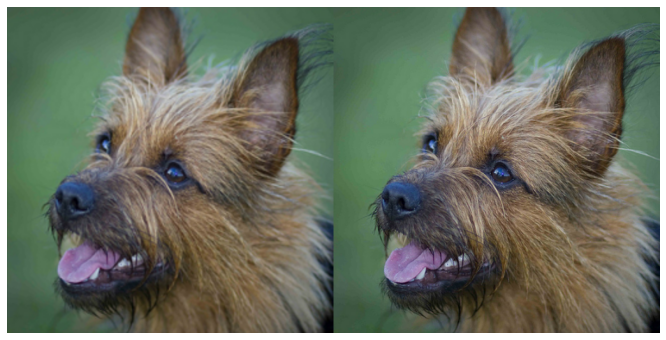

In [32]:
visualize_images(np.vstack([ur_imgs, hr_imgs]))

In [55]:
sr_tokens, sr_imgs = run_sr(maskgit, maskgit_params, ur_imgs)

In [34]:
hr_tokens = encode_imgs_to_tokens(hr_imgs)
ur_tokens = encode_imgs_to_tokens(ur_imgs)

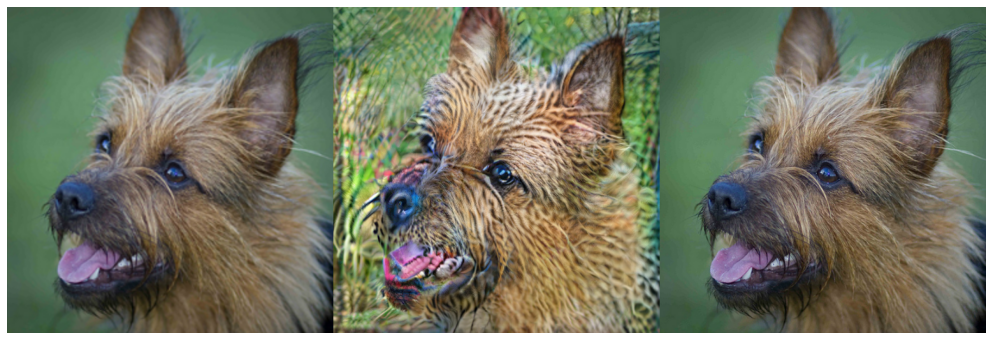

In [36]:
visualize_images(np.vstack([ur_imgs, sr_imgs, hr_imgs]))

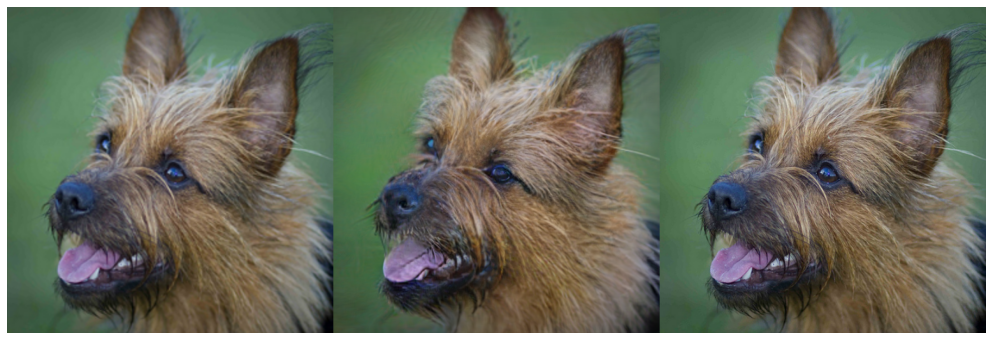

In [56]:
visualize_images(np.vstack([ur_imgs, sr_imgs, hr_imgs]))

In [44]:
from cv2 import PSNR
from skimage.metrics import structural_similarity as ssim

def eval_img(output, original):
  return PSNR(np.array(output), np.array(original)), ssim(np.array(output), np.array(original), multichannel=True)

In [71]:
eval_img(sr_imgs[0], hr_imgs[0])

(71.19426976626045, 0.7135644292177684)

In [72]:
eval_img(re_imgs[0], hr_imgs[0])

(71.00161156590791, 0.7006794135233744)

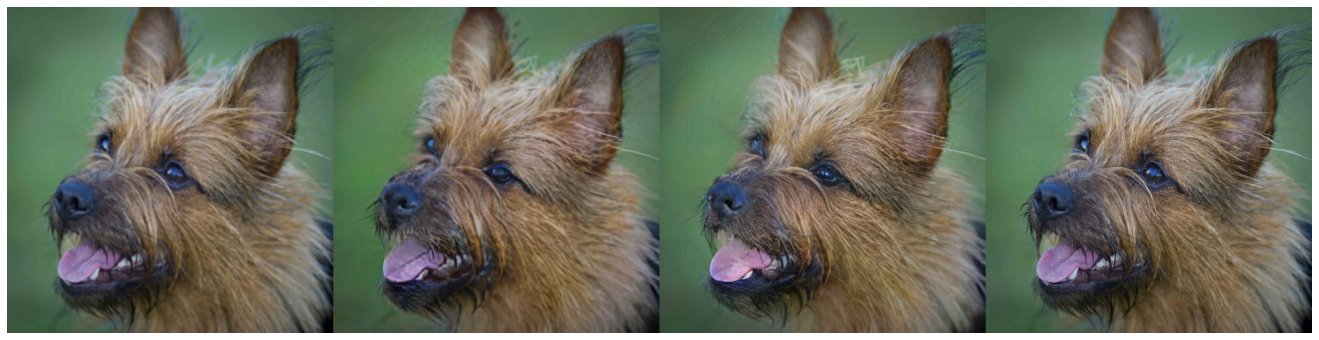

In [69]:
re_imgs = decode_tokens_to_imgs(hr_tokens)

visualize_images(np.vstack([ur_imgs, sr_imgs, re_imgs, hr_imgs]))

In [50]:
from tqdm.notebook import tqdm
val_loader = DataLoader(div2k_val_dataset, batch_size=1, shuffle=False)

psnr_vals = []
ssim_vals = []
for _, hr_imgs, ur_imgs in tqdm(val_loader):
  _, sr_imgs = run_sr(maskgit, maskgit_params, ur_imgs)
  psnr_val, ssim_val = eval_img(sr_imgs[0], hr_imgs[0])
  psnr_vals.append(psnr_val)
  ssim_vals.append(ssim_val)

mean_psnr, mean_ssim = np.mean(psnr_vals), np.mean(ssim_vals)

  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
psnr_vals, ssim_vals

(67.74182876769662, 0.6218925124403194)